In [16]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import umap

In [6]:
metrics = pd.read_csv("csv/patients.csv")
metrics['Genetic_mutation_frame_type'] = (metrics['Genetic_mutation_frame_type'] == "Out of frame").astype(int)
metrics_data = metrics.loc[:, ~metrics.columns.isin(["key", "individual", "CASE_ID", "Glucocorticoid_Use", "Disease_Type"])]
features = metrics_data.columns.values
metrics_data = metrics_data.values
isoforms = pd.read_csv("csv/affected_isoforms.csv")
isoforms['Genetic_mutation_frame_type'] = (isoforms['Genetic_mutation_frame_type'] == "Out of frame").astype(int)
isoforms_data = isoforms.loc[:, ~isoforms.columns.isin(["key", "Disease_Type"])]
isoforms_data = isoforms_data.values
exons = pd.read_csv("csv/affected_exons.csv")
exons['Genetic_mutation_frame_type'] = (exons['Genetic_mutation_frame_type'] == "Out of frame").astype(int)
exons_data = exons.loc[:, ~exons.columns.isin(["key", "Disease_Type"])]
exons_data = exons_data.values
tissues = pd.read_csv("csv/patient_tpm.csv")
tissues['Genetic_mutation_frame_type'] = (tissues['Genetic_mutation_frame_type'] == "Out of frame").astype(int)
tissues_data = tissues.loc[:, ~tissues.columns.isin(["key", "Disease_Type"])]
tissues_data = tissues_data.values

(563, 82)


UMAP

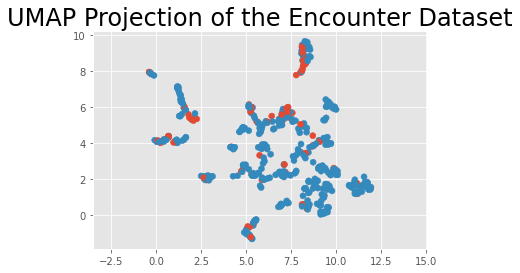

In [26]:
reducer = umap.UMAP()
scaled_metrics = StandardScaler().fit_transform(metrics_data)
embedding = reducer.fit_transform(scaled_metrics)
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=[sns.color_palette()[x] for x in metrics.Disease_Type.map({"BMD": 0, "DMD": 1})])
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP Projection of the Encounter Dataset', fontsize=24)
plt.show()

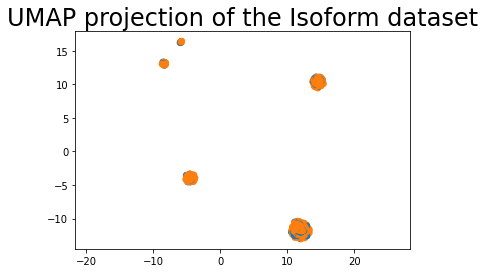

In [12]:
reducer = umap.UMAP()
embedding = reducer.fit_transform(isoforms.drop(["key", "Disease_Type", "Genetic_mutation_frame_type"], axis=1))
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=[sns.color_palette()[x] for x in isoforms.Disease_Type.map({"BMD": 0, "DMD": 1})])
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the Isoform dataset', fontsize=24)
plt.show()

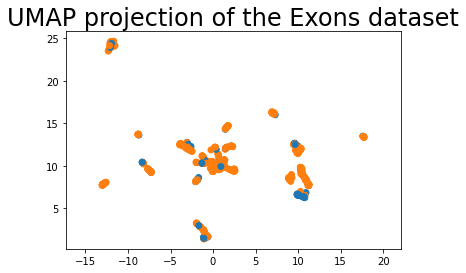

In [7]:
reducer = umap.UMAP()
embedding = reducer.fit_transform(exons.drop(["key", "Disease_Type"], axis=1))
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=[sns.color_palette()[x] for x in exons.Disease_Type.map({"BMD": 0, "DMD": 1})])
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the Exons dataset', fontsize=24)
plt.show()

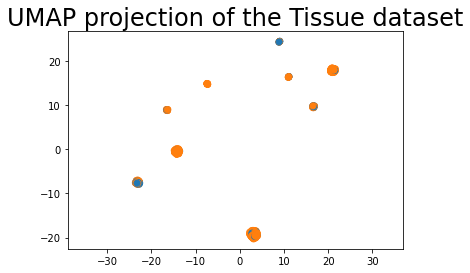

In [3]:
reducer = umap.UMAP()
embedding = reducer.fit_transform(tissues.drop(["key", "Disease_Type"], axis=1))
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=[sns.color_palette()[x] for x in tissues.Disease_Type.map({"BMD": 0, "DMD": 1})])
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the Tissue dataset', fontsize=24)
plt.show()

In [4]:
def scorer(X, y, model):
    cv = StratifiedKFold(random_state=1, shuffle=True)
    scores = cross_val_score(model, X, y, scoring='f1_macro', cv=cv, n_jobs=-1)
    avg = np.mean(scores)
    return avg, scores

In [5]:
X = exons.drop(["key", "Disease_Type"], axis=1)
X = StandardScaler().fit_transform(exons_data)
y = exons["Disease_Type"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, stratify=y)
svclassifier = SVC()
print(scorer(X, y, svclassifier)[0])
svclassifier.fit(X_train, y_train)
y_pred = svclassifier.predict(X_test)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

NameError: name 'exons' is not defined

In [7]:
isoform_lm = LogisticRegression()
print(scorer(X, y, isoform_lm)[0])
isoform_lm.fit(X_train, y_train)
y_pred = isoform_lm.predict(X_test)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

0.7265459520502053
[[11  7]
 [15 80]]
              precision    recall  f1-score   support

         BMD       0.42      0.61      0.50        18
         DMD       0.92      0.84      0.88        95

    accuracy                           0.81       113
   macro avg       0.67      0.73      0.69       113
weighted avg       0.84      0.81      0.82       113



In [24]:
metric_lm = LogisticRegression()
print(scorer(X, y, metric_lm)[0])
metric_lm.fit(X_train, y_train)
y_pred = metric_lm.predict(X_test)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

0.7358685085519674
[[11  7]
 [ 2 93]]
              precision    recall  f1-score   support

         BMD       0.85      0.61      0.71        18
         DMD       0.93      0.98      0.95        95

    accuracy                           0.92       113
   macro avg       0.89      0.80      0.83       113
weighted avg       0.92      0.92      0.91       113



0.7568724861525788
[[10  8]
 [ 6 88]]
              precision    recall  f1-score   support

         BMD       0.62      0.56      0.59        18
         DMD       0.92      0.94      0.93        94

    accuracy                           0.88       112
   macro avg       0.77      0.75      0.76       112
weighted avg       0.87      0.88      0.87       112

{'Patient_Height': 0.2517226718223636, 'Patient_Weight': 0.13004998767552015, 'Feeding_Tube_Placement': 0.0, 'ICD_Placement': 0.0, 'Scoliosis_Surgery': 0.0, 'Tendon_Release_Surgery': 0.0, 'Tracheostomy': 0.0, 'Cushingoid_Features_Diagnosis': 0.013082217160125144, 'Excessive_Weight_Gain_Diagnosis': 0.0, 'Delayed_Puberty_Diagnosis': 0.0, 'Growth_Suppression_Diagnosis': 0.0, 'Hypertension_Diagnosis': 0.0, 'Behavioral_Disturbance_Diagnosis': 0.0, 'Acne_Diagnosis': 0.0, 'Skin_Fragility_Diagnosis': 0.0, 'Diabetes_Diagnosis': 0.0, 'Cataracts_Diagnosis': 0.004179747877617422, 'Gastric_Ulcer_Diagnosis': 0.0, 'Fungal_Infection_Diagnosis'

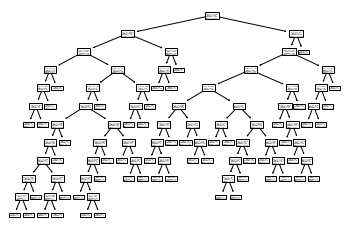

In [9]:
dt = tree.DecisionTreeClassifier()
print(scorer(X, y, dt)[0])
dt = dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)
plt.figure()
tree.plot_tree(dt)
plt.savefig('img/metricstree.svg',format='svg',bbox_inches = "tight")
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(dict(zip(features, dt.feature_importances_)))

0.8062953431814839
[[10  8]
 [ 2 93]]
              precision    recall  f1-score   support

         BMD       0.83      0.56      0.67        18
         DMD       0.92      0.98      0.95        95

    accuracy                           0.91       113
   macro avg       0.88      0.77      0.81       113
weighted avg       0.91      0.91      0.90       113



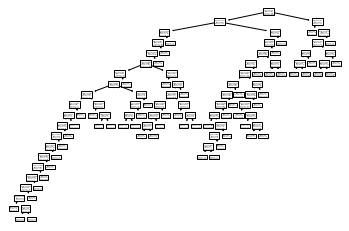

In [19]:
rf = RandomForestClassifier()
print(scorer(X, y, rf)[0])
rf = rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
estimator = rf.estimators_[5]
plt.figure()
tree.plot_tree(estimator)
plt.savefig('img/exonstree.svg',format='svg',bbox_inches = "tight")